## Time series with time structured parameters and summary statistics

Idea: construct a model $p(x|\theta)$ with $\theta = (\theta_1,...\theta_n)$ and summary statistics $s(x) = (s_1(x),...s_m(x))$ s.t.


for all $i$ there exists a $j$, $j\leq m$, and $l$, $j\leq l$ such that
 
$p(s_{1:i}|\theta_{1:n} ) = p(s_{1:i}|\theta_{1:j}) $.

and 

$p(s_{1:i+1}|\theta_{1:n} ) = p(s_{1:i+1}|\theta_{1:l}) $.

### Examples:
1. Piecewise linear function:
 - $\theta_{1,2}$ : a and b of linear function f(x) = ax + b
 - $\theta_{3,4}$ : time of changing point cp, and a2 of second slope

 2. Sinusoidal waves with linearly increasing/decreasing amplitudes, and changing points at which this linear function changes.
 


In [1]:

%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as scp
import matplotlib.pyplot as plt


import sys
sys.path.append('../code/')

import torch

In [2]:
# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import SNPE_C
from utils.helpers import get_time

from utils.sbi_modulated_functions import Combined


from utils.helpers import get_time

## Piecewise_linear() and simulation wrappers for SBI

I defined a seperate function for each sequential step such that we can vary different numbers of parameters

In [3]:
start = get_time()



def piecewise_linear(a1,b, a2,a3, cp1, cp2, add_noise=None):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    

    return y


def piecewise_linear_first_batch(thetas):
    """
    I defined a seperate function for each sequential step such that we can vary different numbers of parameters
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    
    a1 = thetas[0]
    b = thetas[1]
    a2 = np.float32(-2)
    a3 = np.float32(3)
    cp1 = np.float32(3)
    cp2 = np.float32(6)
    
    add_noise=0.5
    
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = torch.arange(0,10,0.01, dtype= torch.float32)
    y = torch.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 

    
    return y


def piecewise_linear_second_batch(thetas):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    
    a1 = thetas[0]
    b = thetas[1]
    a2 = thetas[2]
    a3 = thetas[3]
    cp1 = np.float32(3)
    cp2 = np.float32(6)
    
    add_noise=0.5
    
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = torch.arange(0,10,0.01)
    y = torch.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 

    
    return y


def piecewise_linear_third_batch(thetas):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    
    a1 = thetas[0]
    b = thetas[1]
    a2 = thetas[2]
    a3 = thetas[3]
    cp1 = thetas[4]
    cp2 = thetas[5]
    
    add_noise=0.5
    
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = torch.arange(0,10,0.01)
    y = torch.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 

    
    return y

### Define prior and summary stats dependent on prior

In [4]:
"""
Priors
"""

b = scp.random.uniform(0,10)
a1 = scp.random.uniform(-10,0)
a2 = scp.random.uniform(0,10)
a3 = scp.random.uniform(-10,0)
cp1 = scp.random.uniform(2,4)
cp2 = scp.random.uniform(5,8)


x = piecewise_linear(a1,b, a2,a3, cp1, cp2)



**Summary statistics**

I defined a few more summary statistics such that we have 13 in total.

In [5]:
"""
Summary stats
"""

def extract_sumstats(y,max_time=10):
    """
    Extract some sumstats for piecewise linear fct with specified prior 
    !the information in the sumstats is highly dependent on the prior!
    Args:
        x ([array]): time axis of time series
        y ([array]): 1d time series
        max_time (float, optional): maximal time to calculate sumstats on. Defaults to 10.

    Returns:
       s [array]: summary stats of time series, with np.nan for non-calculated sumstats
    """
    
    # artificial masking of y 
    
    x = torch.arange(0,10,0.01, dtype=torch.float64)

    
    batch_list = []
    # first batch of sumstats for times <4
    
    for batch in y:
        
        
        batch[x>max_time] = np.nan
    
        s = np.zeros(13) * np.nan
        
        s[0] = np.float32(batch[0])    #offset
        s[1] = np.nanmin(batch[x<4])   # local min
        
        #print(type(s[0]), type(s[1]))
        s[2] = x[np.nanargmin(batch[x<4])]   #value of min
        
        s[3] = np.nanmax(batch[x<4])   # local max
        
  
        s[4] = x[np.nanargmax(batch[x<4])]   #value of max

        # second batch of sumstats for times > 4
        if max_time >= 4 :
            s[5] = np.nanmax(batch[(x>=4)&(x<8)])
            s[6] = x[np.nanargmax(batch[(x>=4)&(x<8)])] + 4
            s[9] = np.nanmin(batch[(x>=4)&(x<8)])
            s[10] = x[np.nanargmin(batch[(x>=4)&(x<8)])] +4

        # third batch of sumstats for times > 5
        if max_time >= 5:
            s[7] = np.nanmin(batch[x>=5])
            s[8] = x[np.nanargmin(batch[x>=5])] + 5
            
            s[11] = np.nanmax(batch[x>=5])
            s[12] = x[np.nanargmax(batch[x>=5])] + 5
            
        s = np.float32(s)
    
            
        batch_list.append(torch.from_numpy(s))

    return torch.stack(batch_list)

    

## cosine waves

WORK IN PROGRESS

same, but more ellaborated summary stats are needed

In [6]:
def cosine_waves(a1,b,a2,cp,f_1=1, f_2=1, return_factors=False):
    """
    Args:
        a1 (float): first slope
        b (float): offset (starting amplitude)
        a2 (float): second slope
        cp (float): changing point
        f_1 (float): first freq
        f_2 (float): second freq

    Returns:
        [type]: [description]
    """
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    factor1 = (b+a1*x[x<cp])
    factor1[factor1<0] = 0
    y[x<cp] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp])
     
    factor2= y[np.sum(x<cp)-1] + a2* (x[x>=cp] - cp) 
    factor2[factor2<0] = 0

    y[x>=cp] = (factor2) * np.cos(2*np.pi * f_2 * x[x>=cp]) 

    if return_factors:
        return x,y, factor1, factor2
    else:
        return x,y

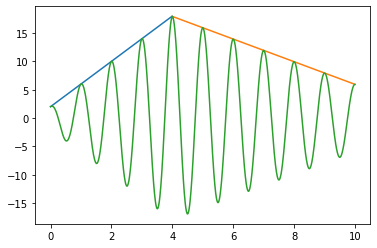

In [7]:
x,y,f1,f2=cosine_waves(4,2,-2,4, return_factors=True  )

plt.plot(x[:len(f1)],f1)
plt.plot(x[-len(f2):],f2)
plt.plot(x,y)

In [8]:
def cosine_waves_2(a1,b,a2,a3, cp1, cp2, f_1=1, f_2=1,f_3=1, return_factors=False):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        ai (float): slopes
        cpi (float): changing points
        f_i (float): first freqs
        
    Returns:
        [type]: [description]
    """
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    factor1 = (b+a1*x[x<cp1])
    factor1[factor1<0] = 0
    y[x<cp1] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp1])
     
    factor2= y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)] - cp1) 
    factor2[factor2<0] = 0
    y[(x>=cp1) & (x<cp2)] = (factor2) * np.cos(2*np.pi * f_2 * x[(x>=cp1) & (x<cp2)]) 
    
    factor3= y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    factor3[factor3<0] = 0

    y[x>=cp2] = (factor3) * np.cos(2*np.pi * f_3 * x[x>=cp2]) 

    if return_factors:
        return x,y, factor1, factor2, factor3
    else:
        return x,y
    
    
def cosine_waves_2_first(thetas):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        ai (float): slopes
        cpi (float): changing points
        f_i (float): first freqs
        
    Returns:
        [type]: [description]
    """
    
    a1 = thetas[0]
    b = thetas[1]
    a2=-3
    a3=3
    cp1=2
    cp2=6
    f_1=1
    f_2=1
    f_3=1
    
    return_factors=False
    
    x = torch.arange(0,10,0.01, dtype= torch.float32)
    y = torch.zeros(x.shape)
    factor1 = (b+a1*x[x<cp1])
    factor1[factor1<0] = 0
    y[x<cp1] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp1])
     
    factor2= y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)] - cp1) 
    factor2[factor2<0] = 0
    y[(x>=cp1) & (x<cp2)] = (factor2) * np.cos(2*np.pi * f_2 * x[(x>=cp1) & (x<cp2)]) 
    
    factor3= y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    factor3[factor3<0] = 0

    y[x>=cp2] = (factor3) * np.cos(2*np.pi * f_3 * x[x>=cp2]) 

    if return_factors:
        return x,y, factor1, factor2, factor3
    else:
        return x,y

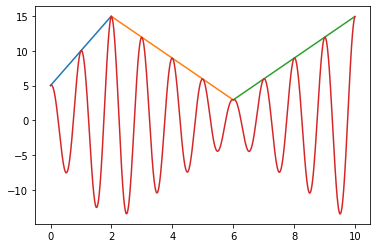

In [9]:
x,y,f1,f2,f3=cosine_waves_2(5,5,
                            -3,3,
                            2,6, return_factors=True)

plt.plot(x[:len(f1)],f1)
plt.plot(x[len(f1):-len(f3)],f2)
plt.plot(x[-len(f3):],f3)

plt.plot(x,y)

## Sequential Time Series SBI


We have the follwoing parameters: a1,b,a2,a3, cp1, cp2

Let's assume this ground truth: true_params = $[5, 5, -3, 2, 1, 5]$

and the following uniform priors: 

prior_min = $[3, 3, -5, 0, -1, 3]  $

prior_max = $[7, 7, -1, 4, 3, 7]$


We start with inferring the first 2 parameters (a1, b), therefore call the function $piecewise_linear_first_batch()$
that only varies these 2 parameters within the prior range.

In [10]:
#parameter a1,b,a2,a3, cp1, cp2



prior_min = [3, 3, -5, 0, -1, 3]  

prior_max = [7, 7, -1, 4, 3, 7]

num_simulations=1000

## First round

In [11]:
### first round:

prior1 = utils.torchutils.BoxUniform(low=prior_min[0:2], high = prior_max[0:2])

print(prior_min[0:2])
print(prior1)

inf = SNPE_C(prior1, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_first_batch, prior1)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

[3, 3]
BoxUniform(Uniform(low: torch.Size([2]), high: torch.Size([2])), 1)


/tmp/ipykernel_138676/4022197506.py:62: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)
/tmp/ipykernel_138676/4022197506.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
x = extract_sumstats(x_without)

In [13]:
inf = inf.append_simulations(theta, x)
density_estimator = inf.train()

posterior = inf.build_posterior(density_estimator)

Neural network successfully converged after 53 epochs.


In [14]:
true_params = [5, 5, -3, 2, 1, 5]
obs_real = piecewise_linear_first_batch(true_params)


print(obs_real.shape)

obs_real_stats = extract_sumstats([obs_real])


print(obs_real_stats.shape)

torch.Size([1000])
torch.Size([1, 13])


In [15]:
num_samples = 100

samples = posterior.sample((num_samples,), x=obs_real_stats)

proposal1 = posterior.set_default_x(obs_real_stats)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
samples_0 = []

for i in samples:
    samples_0.append(i[0])
print(samples_0)

[tensor(4.1550), tensor(4.0080), tensor(4.3687), tensor(4.7687), tensor(4.2705), tensor(3.9786), tensor(3.8630), tensor(4.4501), tensor(3.6618), tensor(3.9102), tensor(4.0530), tensor(3.8167), tensor(3.9572), tensor(3.6723), tensor(3.9314), tensor(3.9948), tensor(4.5596), tensor(4.2646), tensor(5.3806), tensor(4.8267), tensor(3.5710), tensor(4.8717), tensor(3.8360), tensor(4.0383), tensor(3.7511), tensor(4.5865), tensor(3.8787), tensor(3.6533), tensor(3.9680), tensor(3.3706), tensor(4.4732), tensor(3.1350), tensor(4.6185), tensor(4.6919), tensor(3.8652), tensor(3.6905), tensor(3.5651), tensor(5.5585), tensor(3.8978), tensor(4.1801), tensor(4.4857), tensor(4.9267), tensor(3.2401), tensor(4.3731), tensor(3.9475), tensor(3.9795), tensor(3.5604), tensor(3.4694), tensor(3.9103), tensor(4.5719), tensor(3.9807), tensor(3.8904), tensor(4.0637), tensor(5.6187), tensor(4.0587), tensor(4.6483), tensor(4.0262), tensor(4.4576), tensor(4.1747), tensor(4.5373), tensor(4.7304), tensor(4.0552), tensor(

5.618658
3.1349704


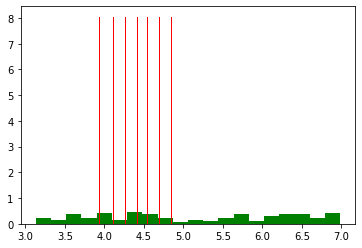

In [17]:
### comparing samples range from posterior and prior:
data = np.random.uniform(prior_min[0],prior_max[0],100) # You are generating 1000 points between 0 and 1.

plt.hist(data, 20, facecolor='green', density=True) 
plt.hist(samples_0, 20, facecolor='red', density=True)


print(np.max(samples_0))
print(np.min(samples_0))

In [18]:
print(prior_max[0]-prior_min[0])
print(np.max(samples_0)-np.min(samples_0))

4
2.4836876


In [19]:
100/(4/0.631)

15.775

So, the parameter range takes now only 15.775% of the uniform prior space!!

## Second round

In [20]:
#### second round



prior2 = utils.torchutils.BoxUniform(low=prior_min[2:4], high = prior_max[2:4])


prior_combined =Combined(proposal1, prior2, number_params_1=2)



inf = SNPE_C(prior_combined, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_second_batch, prior_combined)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 2])
2
theta_posterior tensor([[4.6544, 5.4011]])
theta prior tensor([[-2.1426,  0.9708]])
theta tensor([[ 4.6544,  5.4011, -2.1426,  0.9708]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([2])
1
true
theta_posterior tensor([[4.8577, 5.4216]])
theta prior tensor([[-1.7863,  2.2276]])
theta tensor([[ 4.8577,  5.4216, -1.7863,  2.2276]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 2])
2
theta_posterior tensor([[4.5589, 6.1066]])
theta prior tensor([[-4.1941,  0.6308]])
theta tensor([[ 4.5589,  6.1066, -4.1941,  0.6308]])
tensor([-3.4982])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([2])
1
true
theta_posterior tensor([[4.7308, 6.3572]])
theta prior tensor([[-2.1075,  1.6276]])
theta tensor([[ 4.7308,  6.3572, -2.1075,  1.6276]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([2])
1
true
theta_posterior tensor([[4.8235, 5.9099]])
theta prior tensor([[-1.6968,  3.7435]])
theta tensor([[ 4.8235,  5.9099, -1.6968,  3.7435]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([2])
1
true
theta_posterior tensor([[4.2330, 6.0546]])
theta prior tensor([[-4.9373,  2.8915]])
theta tensor([[ 4.2330,  6.0546, -4.9373,  2.8915]])


Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta pos size torch.Size([2, 2])
theta prior size torch.Size([2, 2])
2
theta_posterior tensor([[4.5714, 6.3414],
        [3.4976, 5.6580]])
theta prior tensor([[-1.8488,  2.0773],
        [-3.2623,  3.3203]])
theta tensor([[ 4.5714,  6.3414, -1.8488,  2.0773],
        [ 3.4976,  5.6580, -3.2623,  3.3203]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([2])
theta prior size torch.Size([2])
1
true
theta_posterior tensor([[3.7260, 6.1497]])
theta prior tensor([[-1.9966,  2.6616]])
theta tensor([[ 3.7260,  6.1497, -1.9966,  2.6616]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 2])
2
theta_posterior tensor([[5.2277, 5.4535]])
theta prior tensor([[-1.7253,  1.7009]])
theta tensor([[ 5.2277,  5.4535, -1.7253,  1.7009]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 2])
theta prior size torch.Size([1, 2])
2
theta_posterior tensor([[3.4084, 5.8339]])
theta prior tensor([[-4.1789,  2.3254]])
theta tensor([[ 3.4084,  5.8339, -4.1789,  2.3254]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta pos size torch.Size([1000, 2])
theta prior size torch.Size([1000, 2])
2
theta_posterior tensor([[4.3270, 5.3535],
        [4.6237, 6.5703],
        [3.8502, 4.9245],
        ...,
        [3.9756, 5.6634],
        [4.5563, 6.4570],
        [4.1138, 5.2247]])
theta prior tensor([[-2.2677,  1.6917],
        [-1.5271,  3.9821],
        [-2.4922,  1.7674],
        ...,
        [-3.7198,  1.1399],
        [-4.9524,  2.2462],
        [-1.9179,  0.6268]])
theta tensor([[ 4.3270,  5.3535, -2.2677,  1.6917],
        [ 4.6237,  6.5703, -1.5271,  3.9821],
        [ 3.8502,  4.9245, -2.4922,  1.7674],
        ...,
        [ 3.9756,  5.6634, -3.7198,  1.1399],
        [ 4.5563,  6.4570, -4.9524,  2.2462],
        [ 4.1138,  5.2247, -1.9179,  0.6268]])


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [21]:
x = extract_sumstats(x_without)



inf = inf.append_simulations(theta, x)


density_estimator = inf.train()

posterior2 = inf.build_posterior(density_estimator)

Neural network successfully converged after 45 epochs.


In [22]:
obs_real = piecewise_linear_second_batch(true_params)


obs_real_stats = extract_sumstats([obs_real])


#print(proposal2.log_prob(theta))

samples = posterior2.sample((num_samples,), x=obs_real_stats)

proposal2 = posterior2.set_default_x(obs_real_stats)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

## Third and last round

In [23]:
#### third round



prior3 = utils.torchutils.BoxUniform(low=prior_min[4:6], high = prior_max[4:6])


prior_combined2 = Combined(proposal2, prior3, number_params_1=4)



inf = SNPE_C(prior_combined2, density_estimator="nsf")

density_estimator = 'nsf'


simulator_stats, prior = prepare_for_sbi(piecewise_linear_third_batch, prior_combined2)

inference = SNPE_C(prior, density_estimator=density_estimator)

theta, x_without = simulate_for_sbi(
    simulator_stats,
    proposal=prior,
    num_simulations=num_simulations,
    num_workers=4,
)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 4])
theta prior size torch.Size([1, 2])
2
theta_posterior tensor([[ 4.6912,  5.8694, -3.8903,  0.8422]])
theta prior tensor([[-0.1495,  6.2261]])
theta tensor([[ 4.6912,  5.8694, -3.8903,  0.8422, -0.1495,  6.2261]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([4])
theta prior size torch.Size([2])
1
true
theta_posterior tensor([[ 4.6968,  6.0828, -1.6802,  1.2348]])
theta prior tensor([[0.4172, 4.8864]])
theta tensor([[ 4.6968,  6.0828, -1.6802,  1.2348,  0.4172,  4.8864]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 4])
theta prior size torch.Size([1, 2])
2
theta_posterior tensor([[ 5.1730,  5.4838, -2.7577,  1.0391]])
theta prior tensor([[1.3791, 6.2945]])
theta tensor([[ 5.1730,  5.4838, -2.7577,  1.0391,  1.3791,  6.2945]])
tensor([-5.1437])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([4])
theta prior size torch.Size([2])
1
true
theta_posterior tensor([[ 5.3426,  6.0152, -1.6734,  0.9134]])
theta prior tensor([[2.5642, 3.0333]])
theta tensor([[ 5.3426,  6.0152, -1.6734,  0.9134,  2.5642,  3.0333]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([4])
theta prior size torch.Size([2])
1
true
theta_posterior tensor([[ 5.1511,  4.6056, -2.0795,  1.4612]])
theta prior tensor([[-0.0162,  5.1081]])
theta tensor([[ 5.1511,  4.6056, -2.0795,  1.4612, -0.0162,  5.1081]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([4])
theta prior size torch.Size([2])
1
true
theta_posterior tensor([[ 4.7119,  6.0152, -2.1592,  1.3454]])
theta prior tensor([[0.8493, 4.6161]])
theta tensor([[ 4.7119,  6.0152, -2.1592,  1.3454,  0.8493,  4.6161]])


Drawing 2 posterior samples:   0%|          | 0/2 [00:00<?, ?it/s]

theta pos size torch.Size([2, 4])
theta prior size torch.Size([2, 2])
2
theta_posterior tensor([[ 5.2722,  6.0454, -1.7078,  0.9481],
        [ 4.8996,  5.8041, -3.1982,  0.7352]])
theta prior tensor([[-0.8005,  5.0480],
        [ 0.9790,  5.8660]])
theta tensor([[ 5.2722,  6.0454, -1.7078,  0.9481, -0.8005,  5.0480],
        [ 4.8996,  5.8041, -3.1982,  0.7352,  0.9790,  5.8660]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([4])
theta prior size torch.Size([2])
1
true
theta_posterior tensor([[ 5.0094,  6.1390, -1.7345,  1.2261]])
theta prior tensor([[-0.2908,  5.7098]])
theta tensor([[ 5.0094,  6.1390, -1.7345,  1.2261, -0.2908,  5.7098]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 4])
theta prior size torch.Size([1, 2])
2
theta_posterior tensor([[ 4.8546,  5.9748, -1.9537,  1.5928]])
theta prior tensor([[2.6534, 6.2609]])
theta tensor([[ 4.8546,  5.9748, -1.9537,  1.5928,  2.6534,  6.2609]])


Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

theta pos size torch.Size([1, 4])
theta prior size torch.Size([1, 2])
2
theta_posterior tensor([[ 4.7851,  6.5710, -2.1233,  1.0655]])
theta prior tensor([[-0.1408,  5.2180]])
theta tensor([[ 4.7851,  6.5710, -2.1233,  1.0655, -0.1408,  5.2180]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

theta pos size torch.Size([1000, 4])
theta prior size torch.Size([1000, 2])
2
theta_posterior tensor([[ 5.0709,  5.9370, -2.0309,  1.1880],
        [ 5.4063,  6.1798, -1.7899,  1.5737],
        [ 5.0620,  6.1106, -1.6738,  0.7013],
        ...,
        [ 5.5227,  6.2873, -3.2993,  1.1010],
        [ 4.8728,  5.6387, -2.0878,  1.5977],
        [ 4.6617,  6.0292, -2.2685,  1.5013]])
theta prior tensor([[ 0.9250,  6.5699],
        [ 2.8928,  6.5135],
        [ 0.3528,  6.2372],
        ...,
        [-0.6153,  5.0003],
        [ 2.2620,  5.2470],
        [ 2.7737,  5.5879]])
theta tensor([[ 5.0709,  5.9370, -2.0309,  1.1880,  0.9250,  6.5699],
        [ 5.4063,  6.1798, -1.7899,  1.5737,  2.8928,  6.5135],
        [ 5.0620,  6.1106, -1.6738,  0.7013,  0.3528,  6.2372],
        ...,
        [ 5.5227,  6.2873, -3.2993,  1.1010, -0.6153,  5.0003],
        [ 4.8728,  5.6387, -2.0878,  1.5977,  2.2620,  5.2470],
        [ 4.6617,  6.0292, -2.2685,  1.5013,  2.7737,  5.5879]])


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [24]:
x = extract_sumstats(x_without)



inf = inf.append_simulations(theta, x)


density_estimator = inf.train()

posterior3 = inf.build_posterior(density_estimator)

Neural network successfully converged after 46 epochs.


In [25]:
obs_real = piecewise_linear_third_batch(true_params)


obs_real_stats = extract_sumstats([obs_real])


samples = posterior3.sample((num_samples,), x=obs_real_stats)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
end = get_time()


print('start:', start, '\nend:', end)

start: 12-08-2021_09:30:26 
end: 12-08-2021_09:32:41


In [28]:
from joblib import Parallel, delayed

num_workers = 4
x_lin = torch.arange(0,10,0.01, dtype= torch.float32)
s_x = Parallel(
        n_jobs=num_workers,
        verbose=0,
        pre_dispatch="1.5*n_jobs",
        backend="multiprocessing",
    )(delayed(piecewise_linear_third_batch)(sample) for sample in samples)

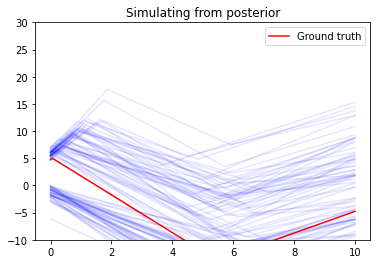

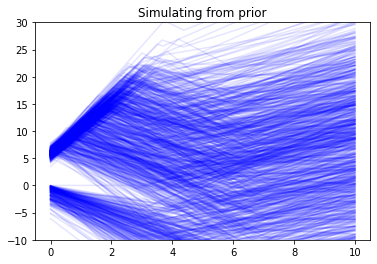

In [29]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from posterior")
for s in s_x:
    im = plt.plot(x_lin, s, alpha=0.1, color='blue')
    plt.ylim(-10,30)
plt.plot(x_lin, obs_real, label='Ground truth', color='red')
plt.legend()
    
    
    
fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from prior")
for x_w in x_without:
    plt.plot(x_lin, x_w, alpha=0.1, color='blue')

    plt.ylim(-10,30)


    
    
true_params = [5, 5, -3, 2, 1, 5]
obs_real = piecewise_linear_third_batch(true_params)

In [ ]:
limits = [list(tup) for tup in zip(prior_min, prior_max)]

true_params = torch.tensor([[5, 5, -3, 2, 1, 5]])

parameter_names = ['a1', 'b', 'a2', 'a3', 'cp1', 'cp2' ]

fig, axes = analysis.pairplot(
    samples,
    limits=limits,
    ticks=limits,
    figsize=(5, 5),
    points=true_params[0:2],
    points_offdiag={"markersize": 6},
    points_colors="r",
    #tick_labels=parameter_names
    labels=parameter_names,
)

In [ ]:
import matplotlib.gridspec as gridspec

x = x

s_real = obs_real_stats[0]



print(x.shape)


print(len(s_x))

fig = plt.figure(figsize=(10,40), tight_layout=True)

gs = gridspec.GridSpec(nrows=x.size(dim=1), ncols=1)


sum_stats_names = torch.arange(1, 14, 1)

print(sum_stats_names)



#fig.suptitle('Summary stats histogram from posterior predictions.', y=0.2, fontsize=16)


for i in range(len(sum_stats_names)-1):

    globals()['ax%s' % i] = fig.add_subplot(gs[i])

    globals()['sum_stats%s' % i] = []
    globals()['x%s' % i] = []

    for j in range(len(s_x)-1):
        globals()['sum_stats%s' % i].append(s_x[j][i])
        globals()['x%s' % i].append(x[j][i])



    globals()['ax%s' % i].hist(globals()['sum_stats%s' % i],  density=False, facecolor='g', alpha=0.75, histtype='barstacked', label='from posterior')
    globals()['ax%s' % i].hist(globals()['x%s' % i],  density=False, facecolor='b', alpha=0.75, histtype='barstacked', label='simulated')
    
  
    globals()['ax%s' % i].set_title('Histogram of summary stat "{}" '.format(sum_stats_names[i]), pad=20)
    #ax0.set(ylim=(-500, 7000))

    globals()['ax%s' % i].axvline(s_real[i], color='red', label='ground truth')
    globals()['ax%s' % i].legend(loc='upper right')





plt.savefig('Summary_stats_post_prior')